In [1]:
from __future__ import print_function

import tensorflow as tf
from tensorflow.contrib import rnn
import numpy as np
import pandas as pd
import os.path
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [2]:
# ------------------------------------------------
# Directories
MODEL_FOLDER = "../../../models/lstm/"
MODEL_FILENAME = MODEL_FOLDER + "1Q/64_units/"

In [3]:
# ------------------------------------------------
# Helper fct: model saver
def saveModel(sess, MODEL_FILENAME):
    if not os.path.exists(MODEL_FOLDER):
        print('Creating path where to save model: ' + MODEL_FOLDER)
        os.mkdir(MODEL_FOLDER)

    #print('Saving model at: ' + MODEL_FILENAME)
    saver = tf.train.Saver()
    saver.save(sess, MODEL_FILENAME)
    #print('Model successfully saved.\n')

# ------------------------------------------------
# Helper fct: model loader
def loadModel(sess, MODEL_FILENAME):
    if os.path.exists(MODEL_FILENAME + ".index"):
        print('Loading save model from: ' + MODEL_FILENAME)
        saver = tf.train.Saver()
        saver.restore(sess, MODEL_FILENAME)
        print('Model successfully loaded.\n')
        return True
    else:
        print('Model file <<' + MODEL_FILENAME + '>> does not exists!')
        return False


In [4]:
# ------------------------------------------------
# Hyperparameters
epochs = 500
learning_rate = 1e-1
batch_size = 5
early_stop_iters = 10
folds = 32

# Network Parameters
n_input = 3  # data input
n_steps = 4  # timesteps
n_hidden = 64 # dimension of recurrent unit

# (REPRODUCIBILITY) set random seeds
tf.set_random_seed(123)

# Define weights and biases
weights = {
    'out': tf.Variable(tf.truncated_normal([n_hidden, 1], stddev = 1.0 / tf.sqrt(float(n_hidden))),
        name='out_weight')
}
biases = {
    'out': tf.Variable(tf.zeros([1]),
        name='out_bias')
}


In [5]:
# ------------------------------------------------
# Helper fct: Build model
def RNN(X, weights, biases, n_hidden):

    # Define a LSTM cell with tensorflow
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(n_hidden, state_is_tuple=True)
    outputs, _ = tf.nn.dynamic_rnn(lstm_cell, X, dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    out_layer = tf.matmul(outputs[:,-1,:], weights['out']) + biases['out']

    return out_layer

# ------------------------------------------------
# Helper fct: select batch
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)


In [6]:
# =================================
# 0. Load dataset
# =================================
print("Loading the data...")
# Training set pre-processing
train = pd.read_csv('../../../Data/train.csv')
train_4lag_inflation = np.array(train[['inflation.lag1',
                                       'inflation.lag2',
                                       'inflation.lag3',
                                       'inflation.lag4']])
train_4lag_unemp = np.array(train[['unemp.lag1',
                                   'unemp.lag2',
                                   'unemp.lag3',
                                   'unemp.lag4']])
train_4lag_oil = np.array(train[['oil.lag1',
                                 'oil.lag2',
                                 'oil.lag3',
                                 'oil.lag4']])
train_features = np.concatenate((train_4lag_inflation[:,:,np.newaxis], 
	                             train_4lag_unemp[:,:,np.newaxis],
	                             train_4lag_oil[:,:,np.newaxis]),
	                             axis=2)
train_target = np.array(train['inflation.target'])

# Test set pre-processing
test = pd.read_csv('../../../Data/test.csv')
test_4lag_inflation = np.array(test[['inflation.lag1',
                                     'inflation.lag2',
                                     'inflation.lag3',
                                     'inflation.lag4']])
test_4lag_unemp = np.array(test[['unemp.lag1',
                                 'unemp.lag2',
                                 'unemp.lag3',
                                 'unemp.lag4']])
test_4lag_oil = np.array(test[['oil.lag1',
                               'oil.lag2',
                               'oil.lag3',
                               'oil.lag4']])
test_features = np.concatenate((test_4lag_inflation[:,:,np.newaxis], 
	                            test_4lag_unemp[:,:,np.newaxis],
	                            test_4lag_oil[:,:,np.newaxis]),
	                            axis=2)
test_target = np.array(test['inflation.target'])

(nrTrainSamples, timesteps, variables) = train_features.shape
(nrTestSamples, _, _) = test_features.shape

# Window length and validation fold index
window_length = 65
valIndex = np.linspace(start=window_length, stop=nrTrainSamples, 
                       endpoint=True, num=folds+1, dtype=np.int)

print("Finished: data loaded. Stats below: ")
print("Nr of training samples: %d" % nrTrainSamples)
print("Nr of testing  samples: %d" % nrTestSamples)
print("Number of variables: %d" % variables)
print("Number of lags: %d" % timesteps)
print("Window length: %d" % window_length)
print("Number of validation folds: %d" % folds)

Loading the data...
Finished: data loaded. Stats below: 
Nr of training samples: 193
Nr of testing  samples: 77
Number of variables: 3
Number of lags: 4
Window length: 65
Number of validation folds: 32


In [7]:
# ==================================
# 1. Build model
# ==================================
# tf graph input
x = tf.placeholder("float", [None, n_steps, n_input], name='Batch')
y = tf.placeholder("float", name='True_labels_of_batch')
lr = tf.placeholder("float", name='Learning_rate')

# Make predictions with the model
pred = RNN(x, weights, biases, n_hidden)

# Define loss and optimizer
loss = tf.reduce_mean(tf.diag_part(tf.square(tf.subtract(x=pred, y=y))))
optimizer = tf.train.GradientDescentOptimizer(lr).minimize(loss)

In [8]:
# ==================================
# 2. Train model
# ==================================
sess = tf.InteractiveSession()  # Launch Graph
sess.run(tf.global_variables_initializer())  # Initialise all variables

print("Start training", 
      "\nHyperparameters:",
      "\nDimension of recurrent unit =", n_hidden,
      "\nLearning rate =", learning_rate,
      "\nEpochs =", epochs,
      "\nBatch size =", batch_size,
      "\nEarly stopping epochs =", early_stop_iters,
      "\nLearning rate =", learning_rate)

total_batch = int(window_length / batch_size)
validation_fold_error = [] # store validation error of each fold
optimal_epochs = []

# loop through folds
for fold in range(1, len(valIndex)):
    validx = train_features[valIndex[fold-1]:valIndex[fold]]
    validy = train_target[valIndex[fold-1]:valIndex[fold]]
    trainx = train_features[(fold-1)*4:valIndex[(fold-1)]]
    trainy = train_target[(fold-1)*4:valIndex[(fold-1)]]

    loss_list = [] # store validation loss after each epoch for early stopping
    
    for epoch in range(epochs):
        for i in range(total_batch):
            # Backprop
            batch_xs, batch_ys = next_batch(num=batch_size, data=trainx, labels=trainy)
            optimizer.run(feed_dict={x:batch_xs, y:batch_ys, lr:learning_rate})

        # Loss
        loss_train = sess.run(loss, feed_dict={x:trainx, y:trainy})
        loss_valid = sess.run(loss, feed_dict={x:validx, y:validy})
        loss_list.append(loss_valid)

        print("Fold: {0:d}".format(fold),
              " Epoch: {0:d}".format(epoch+1),
              " Training loss = {0:.4f}".format(np.sqrt(loss_train)),
              " Validation loss = {0:.4f}".format(np.sqrt(loss_valid)),
              " \n")

        if all(j <= loss_valid for j in loss_list[-early_stop_iters:]) and len(loss_list)>early_stop_iters:
            break
    
    # Load model with lowest validation error for each fold
    epoch_hat = np.argmin(loss_list) + 1
    optimal_epochs.append(epoch_hat) # store optimal number of epochs for each fold
    
    # RMSE
    loss_train = sess.run(loss, feed_dict={x:trainx, y:trainy})
    loss_valid = sess.run(loss, feed_dict={x:validx, y:validy})
    validation_fold_error.append(np.sqrt(loss_valid))
    
    print("Check model:",
          " Fold: {0:d}".format(fold),
          " Optimal epoch: {0:d}".format(epoch_hat),
          " \n")


Start training 
Hyperparameters: 
Dimension of recurrent unit = 64 
Learning rate = 0.1 
Epochs = 500 
Batch size = 5 
Early stopping epochs = 10 
Learning rate = 0.1
Fold: 1  Epoch: 1  Training loss = 2.8565  Validation loss = 0.4434  

Fold: 1  Epoch: 2  Training loss = 4.1579  Validation loss = 2.3253  

Fold: 1  Epoch: 3  Training loss = 2.4032  Validation loss = 1.4061  

Fold: 1  Epoch: 4  Training loss = 2.2496  Validation loss = 1.9224  

Fold: 1  Epoch: 5  Training loss = 2.0370  Validation loss = 1.5304  

Fold: 1  Epoch: 6  Training loss = 2.0049  Validation loss = 0.7365  

Fold: 1  Epoch: 7  Training loss = 1.6175  Validation loss = 1.5666  

Fold: 1  Epoch: 8  Training loss = 1.7153  Validation loss = 1.1507  

Fold: 1  Epoch: 9  Training loss = 1.9641  Validation loss = 0.6502  

Fold: 1  Epoch: 10  Training loss = 1.8374  Validation loss = 1.7239  

Fold: 1  Epoch: 11  Training loss = 1.9262  Validation loss = 1.7577  

Fold: 1  Epoch: 12  Training loss = 1.5355  Valida

In [9]:
# ==================================
# 3. Optimal epoch choice
# ==================================
# Pick number of epochs to train model for out-of-sample testing
epoch_hat = int(np.mean(optimal_epochs))
print("\nAverage number of epochs:", epoch_hat)
# Average validation error
print("Average validation error:", np.mean(validation_fold_error))

# Save validated model
saveModel(sess, 
          MODEL_FILENAME + "lr_" + str(learning_rate) + "/" + str(epoch_hat) + "_validated")



Average number of epochs: 8
Average validation error: 4.2886


In [10]:
# ==================================
# 4. Fixed scheme
# ==================================
print("\nFixed scheme:")
for epoch in range(epoch_hat):
    x_train = train_features[-window_length:]
    y_train = train_target[-window_length:]
    optimizer.run(feed_dict={x:x_train, y:y_train, lr:learning_rate})

    loss_train = sess.run(loss, feed_dict={x:x_train, y:y_train})
    loss_test = sess.run(loss, feed_dict={x:test_features, y:test_target})
    print("Epoch: {0:d}".format(epoch+1),
          " Training loss = {0:.4f}".format(np.sqrt(loss_train)),
          " Test loss = {0:.4f}".format(np.sqrt(loss_test)),
          " \n")

# Forecasts
yhat_test_fixed = pred.eval(feed_dict={x:test_features})
yhat_train_fixed = pred.eval(feed_dict={x:x_train})


Fixed scheme:
Epoch: 1  Training loss = 1.5836  Test loss = 2.6664  

Epoch: 2  Training loss = 1.4861  Test loss = 2.8858  

Epoch: 3  Training loss = 1.4348  Test loss = 2.8175  

Epoch: 4  Training loss = 1.4101  Test loss = 2.8150  

Epoch: 5  Training loss = 1.3994  Test loss = 2.8021  

Epoch: 6  Training loss = 1.3918  Test loss = 2.7983  

Epoch: 7  Training loss = 1.3854  Test loss = 2.7941  

Epoch: 8  Training loss = 1.3799  Test loss = 2.7906  



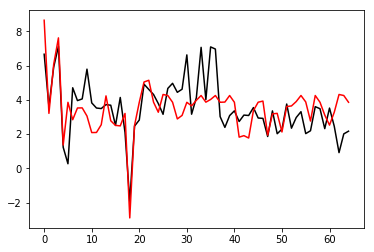

In [11]:
# Train set
plt.plot(y_train, 'black')
plt.plot(yhat_train_fixed, 'red')
plt.show()

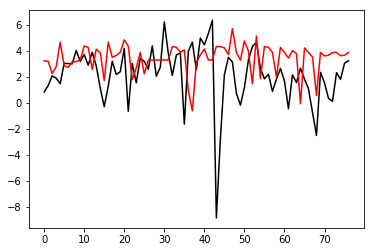

In [12]:
# Test set: fixed scheme
plt.plot(test_target, 'black')
plt.plot(yhat_test_fixed, 'red')
plt.show()

In [13]:
rmse_fixed = np.sqrt(np.mean((yhat_test_fixed[:,0]-test_target)**2))
mae_fixed = np.mean(np.abs((yhat_test_fixed[:,0]-test_target)))
print("Fixed scheme RMSE:", rmse_fixed,
     "\nFixed scheme MAE: ", mae_fixed)

Fixed scheme RMSE: 2.79062783363 
Fixed scheme MAE:  2.03191961927


In [14]:
# Stack training and test set, this makes updating scheme easier to train
all_features = np.concatenate((train_features[-window_length:], test_features), axis=0)
all_target = np.concatenate((train_target[-window_length:], test_target), axis=0)

# Vectors to store loss and forecasts
test_loss = np.zeros(len(test_target))
yhat_update = np.zeros(len(test_target))

In [15]:
retrain_count = 0
for t in range(len(test_target)):
    x_test = np.reshape(test_features[t], newshape=(1,4,3))
    y_test = test_target[t]
    test_loss[t] = np.sqrt(sess.run(loss, feed_dict={x:x_test, y:y_test}))
    yhat_update[t] = pred.eval(feed_dict={x:x_test})

    x_train = all_features[t:(window_length+t)]
    y_train = all_target[t:(window_length+t)]

    loss_train = sess.run(loss, feed_dict={x:x_train, y:y_train})
    loss_test = sess.run(loss, feed_dict={x:x_test, y:y_test})
    
    print("Test period = {0:d}".format(t+1),
      " Training loss = {0:.4f}".format(np.sqrt(loss_train)),
      " Test loss = {0:.4f}".format(np.sqrt(loss_test)),
      " Model updated {0:d} times".format(retrain_count),
      " \n")

    if (t+1)%4==0:
        retrain_count += 1
        for epoch in range(epoch_hat):
            for i in range(total_batch):
                optimizer.run(feed_dict={x:x_train, y:y_train, lr:learning_rate})

Test period = 1  Training loss = 1.3799  Test loss = 2.3863  Model updated 0 times  

Test period = 2  Training loss = 1.3896  Test loss = 1.8696  Model updated 0 times  

Test period = 3  Training loss = 1.4080  Test loss = 0.1720  Model updated 0 times  

Test period = 4  Training loss = 1.4080  Test loss = 0.8745  Model updated 0 times  

Test period = 5  Training loss = 1.1637  Test loss = 3.3437  Model updated 1 times  

Test period = 6  Training loss = 1.2350  Test loss = 0.3360  Model updated 1 times  

Test period = 7  Training loss = 1.1709  Test loss = 0.3068  Model updated 1 times  

Test period = 8  Training loss = 1.1647  Test loss = 0.1112  Model updated 1 times  

Test period = 9  Training loss = 1.0681  Test loss = 0.7575  Model updated 2 times  

Test period = 10  Training loss = 1.0722  Test loss = 0.0871  Model updated 2 times  

Test period = 11  Training loss = 1.0490  Test loss = 0.5907  Model updated 2 times  

Test period = 12  Training loss = 1.0451  Test loss 

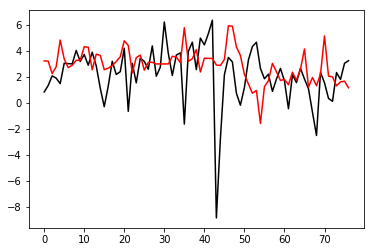

In [16]:
# Test set: updating scheme
plt.plot(test_target, 'black')
plt.plot(yhat_update, 'red')
plt.show()

In [17]:
rmse_update = np.sqrt(np.mean((yhat_update-test_target)**2))
mae_update = np.mean(np.abs((yhat_update-test_target)))
print("Updating scheme RMSE:", rmse_update,
     "\nUpdating scheme MAE: ", mae_update)

Updating scheme RMSE: 2.53600641321 
Updating scheme MAE:  1.75422506062


In [18]:
np.savetxt(MODEL_FILENAME + "lr_" + str(learning_rate) + "/" + "yhat_test_fixed.csv", yhat_test_fixed)
np.savetxt(MODEL_FILENAME + "lr_" + str(learning_rate) + "/" + "yhat_update.csv", yhat_update)